In [1]:
from time import sleep
from selenium import webdriver
from string import punctuation
import re
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import copy
import matplotlib.pyplot as plt
%pylab inline
import numpy as np
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


C:\Users\bandi\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### 1& 2.) Fetching 5000 posts from Edmunds.com luxury forum

Website - https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p702

In [24]:
driver = webdriver.Chrome('C:/Users/bandi/Desktop/Text Analytics/TA Session/chromedriver_win32/chromedriver')
driver.get('https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p702')


In [156]:
#Creating empty data frame to store user_id, dates and comments from ~5K users.
comments = pd.DataFrame(columns = ['Date','user_id','comments'])

j = 702
while (j>=1):
    # Running while loop only till we get 5K comments 
    if (len(comments)<5000):
        url = 'https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p' + str(j)
        driver.get(url)
        ids = driver.find_elements_by_xpath("//*[contains(@id,'Comment_')]")
        comment_ids = []
        for i in ids:
            comment_ids.append(i.get_attribute('id'))

        for x in comment_ids:
            #Extract dates from for each user on a page
            user_date = driver.find_elements_by_xpath('//*[@id="' + x +'"]/div/div[2]/div[2]/span[1]/a/time')[0]
            date = user_date.get_attribute('title')

            #Extract user ids from each user on a page
            userid_element = driver.find_elements_by_xpath('//*[@id="' + x +'"]/div/div[2]/div[1]/span[1]/a[2]')[0]
            userid = userid_element.text

            #Extract Message for each user on a page
            user_message = driver.find_elements_by_xpath('//*[@id="' + x +'"]/div/div[3]/div/div[1]')[0]
            comment = user_message.text
            
            #Extracting Block Quote if Present
            block_quote = driver.find_element_by_xpath('//*[@id="' + x + '"]/div/div[3]/div/div[1]')
            block_quote_class = block_quote.find_elements_by_class_name('UserQuote')
            block_text = ''
            if len(block_quote_class)>0:
                block_text = block_quote_class[0].text
            
            #Replacing block quotes
            comment = comment.replace(block_text,"")
            
           #Adding date, userid and comment for each user in a dataframe    
            comments.loc[len(comments)] = [date,userid,comment]
        j=j-1
    else:
        break        

In [157]:
import copy
comments_copy = copy.deepcopy(comments)

def remove_space(s):
    return s.replace("\n"," ")

comments_copy['comments'] = comments_copy['comments'].apply(remove_space)
comments_copy.to_csv('comments.csv', header=True, sep=',') 

### Cleansing the posts we fetched from Edmunds.com

In [2]:
comments_copy = pd.read_csv('comments.csv')
models = pd.read_csv("models.csv", header = None, names = ['brand','model'], encoding='windows-1252')
comments_copy = comments_copy.dropna()
comments_copy.reset_index(inplace  = True)

In [3]:
def removepunc(item):
    for p in punctuation:
        item = item.lstrip().replace(p,'')
    return item

def lowerize(x):
    return x.lower()

comments_copy['comments_clean'] = comments_copy['comments'].apply(removepunc).apply(lowerize)
models['brand'] = models['brand'].apply(removepunc)

In [4]:
def model_to_brand(s):
    for i in models.index.values:
        s = s.replace(models["model"][i].lower(),models["brand"][i].lower())
    return s
comments_copy['comments_model_replace'] = comments_copy['comments_clean'].apply(model_to_brand)

In [5]:
comments_copy['comments_appear'] = comments_copy['comments_model_replace'].apply(word_tokenize).apply(set).apply(list)

# Remove stop words
stop_words = set(stopwords.words('english'))
def remove_stopwords(s):
    return [w for w in s if not w in stop_words] 
    
comments_copy['final_comments'] =  comments_copy['comments_appear'].apply(remove_stopwords)
#filtered_sentence = [w for w in temp['comments_appear'] if not w in stop_words]

In [6]:
count = []
for i in range(len(comments_copy)):
    count+=comments_copy['final_comments'][i]

In [7]:
from nltk import FreqDist
word_freq = nltk.FreqDist(count)

In [8]:
models_unique = models['brand'].drop_duplicates().tolist()

In [9]:
top_words = word_freq.most_common(500)
top_brands = []
for (key, items) in top_words:
    if key in models_unique:
        model_counts = (key,items)
        top_brands.append(model_counts)        

### 3. Top 10 brands 

In [10]:
top_15_brands_counts = top_brands[:15]
print ('Below are the top 10 brands along with their frequencies\n' , top_15_brands_counts[:10])

Below are the top 10 brands along with their frequencies
 [('bmw', 1353), ('audi', 1088), ('acura', 535), ('mercedes', 400), ('cadillac', 339), ('honda', 325), ('infiniti', 253), ('ford', 244), ('volkswagen', 229), ('lexus', 198)]


## Task A: Calculate lift ratios for associations between brands. Show the brands on a MDS map.

In [11]:
# Fetching the top 10 brands.
top_15_brands =[]
for brand, count in top_15_brands_counts:
    top_15_brands.append(brand)    

In [12]:
new_df = pd.DataFrame(columns = top_15_brands)

def brand_mentioned(item):
    if brand in item:
        return 1
    else:
        return 0
      
for brand in top_15_brands:
    new_df[brand] = comments_copy['final_comments'].apply(brand_mentioned)    

In [13]:
# Calculating lift among top brands
df2=pd.DataFrame(columns = top_15_brands)
for i in range(len(top_15_brands)):
    new_list = []
    for j in range(len(top_15_brands)):
        if (i!=j):
            numerator = ((new_df[top_15_brands[i]] + new_df[top_15_brands[j]]) > 1).sum()
            denominator = new_df[top_15_brands[j]].sum()*new_df[top_15_brands[i]].sum()
            lift = numerator*len(new_df)/denominator
            df2.loc[top_15_brands[i],top_15_brands[j]] = lift
print ('Below are the lift ratios among top brands\n')
df2

Below are the lift ratios among top brands



,bmw,audi,acura,mercedes,cadillac,honda,infiniti,ford,volkswagen,lexus,hyundai,kia,toyota,volvo,subaru
bmw,NaN,1.50198,1.37901,2.27786,1.62135,1.03288,1.85171,1.69324,1.17592,2.31018,1.39087,1.6366,1.23945,2.05661,1.09668
audi,1.50198,NaN,2.00641,2.51156,2.17864,1.65143,2.59283,1.14683,2.26361,2.68752,1.62937,1.19529,1.32115,2.27336,1.90105
acura,1.37901,2.00641,NaN,2.58879,2.14649,3.64548,4.24044,0.87937,1.38509,3.62793,1.17249,0.985455,1.71653,2.80695,1.34472
mercedes,2.27786,2.51156,2.58879,NaN,3.16538,1.91962,3.45227,1.73867,1.41666,5.3565,2.11367,1.66952,1.69694,4.19597,1.1241
cadillac,1.62135,2.17864,2.14649,3.16538,NaN,1.40432,3.49155,1.56881,1.02866,4.75886,2.09175,1.34785,1.76673,3.64811,1.59164
honda,1.03288,1.65143,3.64548,1.91962,1.40432,NaN,1.82098,1.63639,2.41419,2.55949,2.18186,2.59554,5.40564,0.815412,2.35196
infiniti,1.85171,2.59283,4.24044,3.45227,3.49155,1.82098,NaN,1.53614,1.80905,7.47245,2.04819,1.94494,2.36727,4.36444,2.84357
ford,1.69324,1.14683,0.87937,1.73867,1.56881,1.63639,1.53614,NaN,2.14375,1.54962,2.34729,3.16907,2.12731,1.81017,3.31701
volkswagen,1.17592,2.26361,1.38509,1.41666,1.02866,2.41419,1.80905,2.14375,NaN,1.54104,2.02465,1.68833,2.78973,1.92874,2.74889
lexus,2.31018,2.68752,3.62793,5.3565,4.75886,2.55949,7.47245,1.54962,1.54104,NaN,3.1681,3.19526,6.25135,5.57679,2.72509


### MDS plot

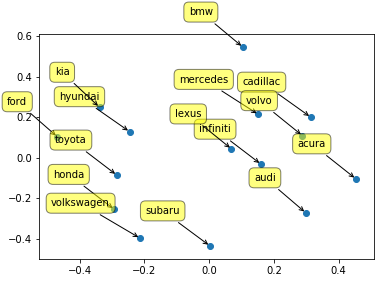

In [14]:
# Calculating the dissimilarity matrix which is the input for plotting MDS plot
dissimilarity_matrix = 1/df2
np.fill_diagonal(dissimilarity_matrix.values, 0)

# Plotting MDS plot
from sklearn import manifold
seed = np.random.RandomState(seed=3)
mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, 
      random_state=seed, dissimilarity="precomputed", n_jobs=1)
results = mds.fit(dissimilarity_matrix)
coords = results.embedding_

plt.subplots_adjust(bottom = 0.1)
plt.scatter(
    coords[:, 0], coords[:, 1], marker = 'o'
    )
for label, x, y in zip(top_15_brands, coords[:, 0], coords[:, 1]):
    
    plt.annotate(
        label,
        xy = (x, y), xytext = (-30, 30),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

plt.show()

### Task B: What insights can you offer brand managers from your analysis in Task A (choose two brands that you can offer the most interesting/useful insights for)? 

**Volvo** is usually associated with safety. However it seems to be associated with other luxury brands such as Acura, Audi, etc. Further Volvo is recently using digital services, flexible ownership models and unconvential advertising to attract younger buyers, while also expressing its luxury credentias more clearly to compete with other luxury brands such as Audi, BMW, etc.

**Cadillac** is also associated with luxury brands. It had invested ~$5b to remake its brand and it seems to have made some impact at least in terms of what people are talking about Cadillac.

### Task C:
### i.) What are 5 most frequently mentioned attributes of cars in the discussions?

In [15]:
attributes = pd.read_csv('attributes.csv')

In [16]:
def word_to_attributes(s):
    s = " ".join(str(x) for x in s)
    for i in attributes.index.values:
        s = s.replace(attributes["Attribute"][i].lower(),attributes["Mapping"][i].lower())
    return s
comments_copy['comments_attributes_replace'] = comments_copy['final_comments'].apply(word_to_attributes)

In [17]:
count = []
for i in range(len(comments_copy)):
    count+=comments_copy['comments_attributes_replace'][i]
attr_freq = nltk.FreqDist(count)
attributes_unique = attributes['Mapping'].drop_duplicates().tolist()

top_words = word_freq.most_common(3000)
top_attributes = []
for (key, items) in top_words:
    if key in attributes_unique:
        attribute_counts = (key,items)
        top_attributes.append(attribute_counts) 

In [18]:
top_5_attributes_counts = top_attributes[:5]
print ('Below are the top 5 attributes along with their frequencies\n' , top_5_attributes_counts)

Below are the top 5 attributes along with their frequencies
 [('performance', 332), ('maintenance', 104), ('styling', 66), ('comfort', 53), ('safety', 47)]


### ii.) Which attributes are most strongly associated with which of the top 5 brands?

In [19]:
# Fetching top 5 attrbutes
top_5_attributes =[]
for attribute, count in top_5_attributes_counts:
    top_5_attributes.append(attribute) 

In [20]:
attributes_df = pd.DataFrame(columns = top_5_attributes)

def attribute_mentioned(item):
    if attribute in item:
        return 1
    else:
        return 0
      
for attribute in top_5_attributes:
    attributes_df[attribute] = comments_copy['comments_attributes_replace'].apply(attribute_mentioned)  

In [21]:
# Calculating Lift between top 5 brands and top 5 attributes
df3=pd.DataFrame(columns = top_5_attributes)
top_5_brands = top_15_brands[:5]
for i in range(len(top_5_brands)):
    new_list = []
    for j in range(len(top_5_attributes)):
        numerator = ((new_df[top_5_brands[i]] + attributes_df[top_5_attributes[j]]) > 1).sum()
        denominator = new_df[top_5_brands[i]].sum()*attributes_df[top_5_attributes[j]].sum()
        lift_brand_attributes = numerator*len(attributes_df)/denominator
        df3.loc[top_5_brands[i],top_5_attributes[j]] = lift_brand_attributes

print ('Below are the lift ratios between top 5 brands and top 5 attributes \n')
df3

Below are the lift ratios between top 5 brands and top 5 attributes 



,performance,maintenance,styling,comfort,safety
bmw,1.39263,1.41275,1.52248,1.47226,1.26055
audi,1.54418,1.56977,1.98506,1.80543,1.64451
acura,1.51728,1.58791,2.28984,1.9444,1.68195
mercedes,1.28526,1.17253,1.81491,2.14414,1.04633
cadillac,1.16098,1.2791,1.25812,1.94235,1.26547


### iii.) While BMW has claimed that they are the “ultimate driving machine”, is that how people feel on Edmunds? 

The association of bmw with performance is lower than that of audi or acura with bmw. This shows that probably people don't associate bmw with performace that much. However, what would be interesting to look into is whether the association between bmw and performance is positive (positive sentiment), while the same with acura is negative (negative sentiment). What is interesting is that people associate bmw more with comfort, styling and maintenance than performance. 

## Task D: What advice will you give to a (i) product manager, and (ii) marketing/advertising manager of these brands based on your analysis in Task C? For this assignment, you can assume the sentiment (e.g., that it is positive)

i.) **Product Manager** - 

    a.) BMW: While we are marketing BMW as the 'ultimate driving machine' people are not strongly associating BMW with performance. Thus think about improving the quality of engine/materials and maybe see what are the key performance features people are talking about and potentially try to include them in our cars. 
    
    b.) Audi: While Audi is perceived to be great on performance, comfort, maintenance, and safety, it is hard to differentiate it from acura. As we saw from the MDS plot above Acura and Audi are also closely related and thus its important to diffentiate our product from Acura. We can potentially focus on improving its association with styling to differentiate it with acura.
    
    c.) Acura: While Acura is doing great in terms of styling due to a recent makeover in its strategy to bring back its flagship sports car NSX, it could be loosing to Audi on performance. Thus while Acura should keep on investing into newer designs to identify it as a sport car, it should also invest in improving its performance and adding the features which customers care about.
    
    d.) Mercedes: While Mercedes is doing a great job at comfort, people think that it is not safer to drive Mercedes. From a product's perspective we could consider including additional high quality safety features to try to alleviate any concerns with the same.
    
    e.) Cadillac: While Cadillac has positive associations with safety, the problem is people don't actually associate Cadillac with performance or styling. For example a recent launch XT4 did not met expectations becaue the design lacked luxury appeal. Thus Cadillac should definitely focus on developing cars with a better design and performance.. 
    
ii.) **Marketing** -

    a.) BMW: If we want BMW to be known as the "ultimate driving machine", we would need to highlight the car's/our brand's performance aspects. Based on the the analysis above, although performance has a lift ratio greater than 1, it is not the highest attribute of our brand, BMW. In our advertising and marketing campaigns, we would want to explicitly highlight the performance specifications of a specific model - such as horsepower, speed, mpg, etc.
    
    b.) Audi: For all 5 attributes, it seems like Audi is very closely related to Acura, and from a marketing perspective, we would want to create more brand differentiation to really uniquely position Audi in the luxury car marketplace. From the analysis above, it looks like our strength is in performance mentions - so we might want to further differentiate that and highlight these aspects in our marketing/advertising campaigns. In addition to playing on our strengths, we could improve on our styling attribute since it's one of the top attributes for luxury cars in this market segment.
    
    c.) Acura: As mentioned above, Acura seems to be closely related to Audi in all 5 attributes in our analysis. However, it does slightly outperform Audi in maintenance, styling, comfort, and safety. On par with their rebranding and focus on styling (a more "sporty" look), they are succeeding in this aspect, but they may want to consider further highlighting their performance upgrades so consumers are more aware of these recent changes. This would increase the association of Acura and their performance upgrades in their rebranding initiative
    
    d.) Mercedes: This brands ranks the highest in terms of comfort , but scored the lowest in terms of safety (relative to the brands and attributes analyzed). From a marketing and branding perspective, they are doing a good job of highlighting the comfort and styling of the car, but may want to consider including the vehicle's safety aspects to have a more well-rounded brand image.
    
    e.) Cadillac: As Cadillac is trying to rebrand and position itself in the growing market segments of compact luxury sedans and compact luxury crossovers, the $5 billion marketing doesn't seem to be working very well. Comfort seems to be the highest mentioned attribute for this brand, but it is one of the lowest for the other 4 attributes, specially styling and performance. We would recommend Cadillac to focus their efforts on these two aspects and work closely with the project managers to physically improve on these two attributes (which other brands are succeeding in), before marketing these aspect to the consumers, especially if they want to be associated with the luxury cars in this market segment.

## Task E: Which is the most aspirational brand in your data in terms of people actually wanting to buy or own? 

**Methodology**: We replaced words such as 'wish', 'love to have', 'dream to', 'wanted to', 'dream car', etc. with "aspiration" to calculate the lift (i.e association) between the top brands and the word aspiration. We measured aspirational based on whether a person a sia he/she loved or wished or dreamed to buy a new car and checked which specific models were mentioned by the person. Since all the above mentioned words basically represent aspirations, a higher value of lift denotes the people have a higher aspiration for that particular brand.

In [22]:
aspiration = pd.read_csv("aspiration.csv")

In [23]:
def aspiring(s):
    #s = " ".join(str(x) for x in s)
    for i in aspiration['word'].index.values:
        s = s.replace(aspiration['word'][i],aspiration['aspr'][i])
    return s
comments_copy['comments_asp_replace'] = comments_copy['comments_attributes_replace'].apply(aspiring)

In [24]:
aspiring_df = pd.DataFrame(columns = ['aspiration'])

def aspiring_mentioned(item):
    if asp in item:
        return 1
    else:
        return 0

for asp in aspiration['aspr'].unique():
    aspiring_df[asp] = comments_copy['comments_asp_replace'].apply(aspiring_mentioned)

In [25]:
# Calculating Lift between top 5 brands and aspiration
aspiring_df2=pd.DataFrame(columns = ['aspiration'])
top_5_brands = top_15_brands[:5]
for i in range(len(top_5_brands)):
    new_list = []
    for j in range(len(aspiration['aspr'].unique())):
        numerator = ((new_df[top_5_brands[i]] + aspiring_df['aspiration']) > 1).sum()
        denominator = new_df[top_5_brands[i]].sum()*aspiring_df['aspiration'].sum()
        lift_brand_aspr = numerator*len(aspiring_df)/denominator
        aspiring_df2.loc[top_5_brands[i],'aspiration'] = lift_brand_aspr

print ('Below are the lift ratios between top 5 brands and aspiration \n')
aspiring_df2

Below are the lift ratios between top 5 brands and aspiration 



,aspiration
bmw,1.48655
audi,1.86231
acura,2.31136
mercedes,1.82507
cadillac,2.02163


**Result**: We observed that people have the highest aspiration for Acura among the top 5 brands.

In [26]:
# Exporting the final cleaned data frame
final_df = comments_copy[['Date','user_id','comments','comments_asp_replace']]
final_df.columns = ['Date','user_id','comments','cleaned_comments']
final_df.to_csv('final_data_file.csv', header=True, sep=',') 